In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch as t

t.manual_seed(42)
if t.cuda.is_available(): t.cuda.manual_seed_all(42)

DEVICE = t.device('cuda' if t.cuda.is_available() else 'cpu')

In [3]:
import torch as t

def generate_mock_data(max_len: int, batch_size: int, vocab_size: int, device: t.device):
    """geerates mock data where the target is a simple, non-random pattern."""
    
    # source - create a repeating pattern (e.g., token 2, 3, 4, 2, 3, 4, ...)
    pattern_len = 5
    pattern = t.arange(2, 2 + pattern_len, device=device)
    src_indices = t.cat([pattern] * (max_len // pattern_len + 1))[:max_len]
    src = src_indices.unsqueeze(0).repeat(batch_size, 1)

    # target - summary - take the first half of the source and add BOS/EOS
    tgt_len = (max_len // 2) + 2
    tgt_seq = src[:, :tgt_len - 2].clone() 
    
    # add bos (1) and eos (1) tokens
    bos = t.ones(batch_size, 1, dtype=src.dtype, device=device)
    eos = t.ones(batch_size, 1, dtype=src.dtype, device=device)
    tgt = t.cat([bos, tgt_seq, eos], dim=1) 
    
    # ensure all tokens are within vocab_size
    tgt = t.clamp(tgt, min=0, max=vocab_size - 1)
    src = t.clamp(src, min=0, max=vocab_size - 1)

    return src, tgt

In [4]:
import math
import time
from typing import Optional, Literal
from functools import partial
import torch as t
import torch.nn as nn
from transformers import AutoTokenizer


# fixed absolute positional encoding (fape)
class FAPE(nn.Module): 
    def __init__(self, d_model: int, max_seq_len: int, t_dtype = t.float32):
        super().__init__()

        # compute pe (vector w/ shape (N, d_model))
        pe = t.zeros(max_seq_len, d_model, dtype=t_dtype)
        position = t.arange(0, max_seq_len, dtype=t_dtype).unsqueeze(1)
        div_term = t.exp(t.arange(0, d_model, 2, dtype=t_dtype) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = t.sin(position * div_term) # even indices
        pe[:, 1::2] = t.cos(position * div_term) # odd indices

        # add extra dimension (1) to broadcast a pe table across all examples in a batch during the forward pass
        pe = pe.unsqueeze(0) # shape - (1, N, d_model)
        
        # fape is not learnable. so store the pe table as a constant model state.
        self.register_buffer('pe', pe)
  
    def forward(self, x: t.Tensor) -> t.Tensor:
        # add pe w.r.t the current batch to the input seq x
        current_seq_len = x.size(1)
        current_pe = self.pe[:, :current_seq_len, :] # shape - (1, current_seq_length (< N), d_model) # type: ignore
        x = x + current_pe
        return x


# learned positional embedding (lpe)
class LPE(nn.Module):
    def __init__(self, d_model: int, max_seq_len: int):
        super().__init__()

        # initialize pe as a learnable model parameter with random vals (shape - (N, d_model))
        self.pe = nn.Parameter(t.randn(max_seq_len, d_model))
    
    def forward(self, x: t.Tensor) -> t.Tensor:
        # adding pe to the input seq x
        return x + self.pe[:x.size(1), :].unsqueeze(0)


# rope util func 1 - apply rotation
def apply_rope(x: t.Tensor, freqs_cis: t.Tensor) -> t.Tensor:
    # reshape the input seq x
    x_ = x.float().reshape(x.shape[:-1] + (-1, 2)) # shape - (B, N, D_V // 2, 2) asssuming D_V is even
    
    # takes array of all cos/sin components from x
    x_real, x_imag = x_.unbind(-1) # shape - (B, N, D_V // 2)
    
    # truncated pre-computed frequency table (freqs_cis) to match the actual length of the input seq x, and cast dtype
    freqs_cis_ = freqs_cis[:x.size(1), :].float() # shape: (N, D_V // 2, 2)
    cos, sin = freqs_cis_.unbind(-1) # shape - (N, D_V // 2)
    
    # apply rotation
    x_out_real = x_real * cos - x_imag * sin # shape - (B, N, D_V // 2)
    x_out_imag = x_real * sin + x_imag * cos # shape - (B, N, D_V // 2)
    
    # stack the results
    x_out = t.stack([x_out_real, x_out_imag], dim=-1).flatten(2) # shape - (B, N, D_V)
    return x_out.type_as(x)


# rope util func 2 - compute rotation factors
def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0) -> t.Tensor:
    freqs = 1.0 / (theta ** (t.arange(0, dim, 2)[: (dim // 2)].float() / dim)) # shape (end, dim // 2)
    t_ = t.arange(end, device=freqs.device, dtype=t.float32)
    freqs = t_.outer(freqs) # shape (end, dim // 2)
    freqs_cis = t.stack([t.cos(freqs), t.sin(freqs)], dim=-1) # shape (end, dim // 2, 2
    return freqs_cis


class MHA(nn.Module):
    class StandardAttention(nn.Module):
        def __init__(
                self,
                d_model: int = 512,
                d_V: int = 64,
                projection: bool = True,
                PE_type: str = 'fape',
                freqs_cis: Optional[t.Tensor] = None
            ) -> None:

            super().__init__()
            self.d_model = d_model
            self.d_V = d_V
            self.projection = projection
            self.scaling_factor = 1 / t.sqrt(t.tensor(self.d_V, requires_grad=False, dtype=t.float32))
            
            # pe setup
            self.PE_type = PE_type
            self.freqs_cis = freqs_cis.to(DEVICE) if freqs_cis is not None else None
            if self.PE_type == "rpe": self.relative_pe = nn.Embedding(2 * 51 + 1, self.d_V) # e.g., max rel dist +/- 50

            # qkv proj
            self.query = nn.Linear(in_features=self.d_model, out_features=self.d_V, bias=True)
            self.key = nn.Linear(in_features=self.d_model, out_features=self.d_V, bias=True)
            self.value = nn.Linear(in_features=self.d_model, out_features=self.d_V, bias=True)
            self.output_proj = nn.Linear(in_features=self.d_V, out_features=self.d_model, bias=False)


        def self_attention(self, Q: t.Tensor, K: t.Tensor, V: t.Tensor, mask: Optional[t.BoolTensor] = None) -> t.Tensor:
            # rope applied to q and k
            if self.PE_type == "rope" and self.freqs_cis is not None:
                Q = apply_rope(Q, self.freqs_cis)
                K = apply_rope(K, self.freqs_cis)
            
            K_T = t.transpose(K, -1, -2)  # [b, N, D] -> [b, D, N]
            S = t.matmul(Q, K_T) * self.scaling_factor  # attention score [b, N, N]
            
            if self.PE_type == 'rpe':
                # simplified RPE: Adding a relative position bias term B to S (Self-Attention with RPE)
                seq_len = Q.size(1)
                # Create relative position indices [N, N] in range [-N+1, N-1]
                idx = t.arange(seq_len, device=Q.device)
                rel_pos_indices = idx.unsqueeze(0) - idx.unsqueeze(1)
                # Clamp to max_rel_dist (50) and shift to positive index for embedding lookup
                max_rel = (self.relative_pe.num_embeddings - 1) // 2 
                rel_pos_indices = t.clamp(rel_pos_indices, -max_rel, max_rel) + max_rel
                
                # rel_pos_bias shape: [N, N, D_V]. Sum(Q * rel_pos_bias)
                rel_pos_bias = self.relative_pe(rel_pos_indices).permute(2, 0, 1) # [D_V, N, N]

                # Simplified RPE via a bias matrix B (Transformer-XL / R-Transformer-like)
                # S = S + B -> Bias is broadcasted over batch dimension [b, N, N]
                # To simplify: use the max pool of the D_V dimension as the bias
                B = rel_pos_bias.mean(dim=0).unsqueeze(0) # [1, N, N]
                S = S + B 
            
            if mask is not None: S = t.masked_fill(S, mask==0, -t.inf) # mask (if any)
            A = t.softmax(S, dim=-1) # attention weight
            Z = t.matmul(A, V)  # context vector [b, N, D_V]
            return Z

        def forward(self, x: t.Tensor, mask: Optional[t.BoolTensor] = None) -> t.Tensor:
            Q = self.query(x) # [b, N, D_V]
            K = self.key(x) # [b, N, D_V]
            V = self.value(x) # [b, N, D_V]
            Z = self.self_attention(Q, K, V, mask=mask) # [b, N, D_V]
            O = self.output_proj(Z) if self.projection else Z # [b, N, d_model] 
            return O


    def __init__(self, d_model: int = 512, d_V: int = 64, H: int = 8, PE_type: str = 'fape', freqs_cis: Optional[t.Tensor] = None) -> None: 
        super().__init__()
        self.proj = nn.Linear(in_features=H * d_V, out_features=d_model, bias=False)
        # pass pe info to attention heads
        self.multihead = nn.ModuleList([self.StandardAttention(d_model, d_V, False, PE_type, freqs_cis) for _ in range(H)])
    
    def forward(self, x: t.Tensor, mask: Optional[t.BoolTensor] = None) -> t.Tensor:
        Z = t.cat([head(x, mask) for head in self.multihead], dim=2) 
        O = self.proj(Z)
        return O


class FFN(nn.Module):
    def __init__(self, d_model: int):
        super().__init__()
        self.ffn = nn.Sequential(nn.Linear(d_model, d_model * 4), nn.ReLU(), nn.Linear(d_model * 4, d_model))
    def forward(self, x: t.Tensor) -> t.Tensor:
        return self.ffn(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, d_V: int, H: int, PE_type: str, freqs_cis: Optional[t.Tensor]):
        super().__init__()
        self.norm_attn = nn.LayerNorm(d_model)
        self.attn = MHA(d_model=d_model, d_V=d_V, H=H, PE_type=PE_type, freqs_cis=freqs_cis) # pass pe info
        self.dropout_attn = nn.Dropout(0.1)

        self.ffn = FFN(d_model)
        self.norm_ffn = nn.LayerNorm(d_model)
        self.dropout_ffn = nn.Dropout(0.1)
    
    def forward(self, x: t.Tensor, mask: Optional[t.BoolTensor] = None) -> t.Tensor: # mask added
        # attention block
        norm_x = self.norm_attn(x)
        O = self.attn(norm_x, mask=mask)
        x = x + self.dropout_attn(O)

        # ffn block
        norm_x = self.norm_ffn(x)
        ffn_out = self.ffn(norm_x)
        output = x + self.dropout_ffn(ffn_out)
        return output


class DecoderLayer(nn.Module):
    def __init__(self, d_model: int, d_V: int, H: int, PE_type: str, freqs_cis: Optional[t.Tensor]):
        super().__init__()
        # self-attention block (masked)
        self.norm_self_attn = nn.LayerNorm(d_model)
        self.self_attn = MHA(d_model=d_model, d_V=d_V, H=H, PE_type=PE_type, freqs_cis=freqs_cis) # pass pe info
        self.dropout_self_attn = nn.Dropout(0.1)

        # cross-attention block
        self.norm_cross_attn = nn.LayerNorm(d_model)
        self.cross_attn = MHA(d_model=d_model, d_V=d_V, H=H, PE_type=PE_type, freqs_cis=freqs_cis) # pass pe info
        self.dropout_cross_attn = nn.Dropout(0.1)

        # ffn block
        self.ffn = FFN(d_model)
        self.norm_ffn = nn.LayerNorm(d_model)
        self.dropout_ffn = nn.Dropout(0.1)
    
    def forward(self, x: t.Tensor, memory: t.Tensor, tgt_mask: Optional[t.BoolTensor]) -> t.Tensor:
        # self-attention (masked)
        norm_x = self.norm_self_attn(x)
        O = self.self_attn(norm_x, mask=tgt_mask)
        x = x + self.dropout_self_attn(O)

        # cross attention
        norm_x = self.norm_cross_attn(x)
        cross_out = self.cross_attn(norm_x)
        x = x + self.dropout_cross_attn(cross_out)

        # ffn
        norm_x = self.norm_ffn(x)
        ffn_out = self.ffn(norm_x)
        output = x + self.dropout_ffn(ffn_out)

        return output


class Transformer(nn.Module):
    def __init__(
            self,
            d_model: int,
            d_V: int,
            H: int,
            max_seq_len: int,
            PE_type: Literal['fape', 'lpe', 'rpe', 'rope'] = 'fape',
            n_layers: int = 2,
            device: t.device = DEVICE,
        ):
        super().__init__()
        
        self.device = device
        self.d_model = d_model
        self.d_V = d_V
        self.H = H
        self.PE_type = PE_type
        self.max_seq_len = max_seq_len
        self.tokenizer = AutoTokenizer.from_pretrained('t5-small', model_max_length=max_seq_len) 
        self.vocab_size = len(self.tokenizer)

        # pe
        match PE_type:
            case 'fape': self.positional_encoder = FAPE(d_model, max_seq_len)
            case 'lpe': self.positional_encoder = LPE(d_model, max_seq_len)
            case 'rpe': self.positional_encoder = nn.Identity()
            case 'rope':
                assert d_V % 2 == 0, 'd_V must be even for RoPE'
                self.positional_encoder = nn.Identity()
            case _:
                raise ValueError(f'unknown pe type: {PE_type}')
        self.freqs_cis = None if PE_type != 'rope' else precompute_freqs_cis(d_V, max_seq_len).to(device)

        # encoder
        self.input_token_embedding = nn.Embedding(self.vocab_size, d_model)
        self.dropout_encoder = nn.Dropout(0.1) 
        encoder_layer = partial(EncoderLayer, d_model=d_model, d_V=d_V, H=H, PE_type=self.PE_type, freqs_cis=self.freqs_cis)
        self.encoder = nn.ModuleList([encoder_layer() for _ in range(n_layers)]) # stacking

        # decoder
        self.target_token_embedding = nn.Embedding(self.vocab_size, d_model)
        self.dropout_decoder = nn.Dropout(0.1)
        decoder_layer = partial(DecoderLayer, d_model=d_model, d_V=d_V, H=H, PE_type=self.PE_type, freqs_cis=self.freqs_cis)
        self.decoder = nn.ModuleList([decoder_layer() for _ in range(n_layers)])

        # final head
        self.linear_head = nn.Linear(d_model, self.vocab_size)
        self.to(device, t.float32)


    def _generate_square_subsequent_mask(self, sz: int) -> t.BoolTensor:
        # returns a mask where False indicates position should be masked (set to -inf)
        mask = (t.triu(t.ones(sz, sz)) == 1).transpose(0, 1) # [sz, sz]
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return t.BoolTensor(mask == 0)

    def forward(self, input_ids: t.Tensor, Y_true: t.Tensor) -> t.Tensor:
        src_seq_len = input_ids.size(1)
        tgt_seq_len = Y_true.size(1) - 1 # input for decoder - Y_true[:, :-1]

        # encoder
        input_tokens = self.input_token_embedding(input_ids) * math.sqrt(self.d_model)
        enc_input = self.dropout_encoder(self.positional_encoder(input_tokens)) # apply pe
        encoder_output = enc_input # forward pass
        for enc_layer in self.encoder: encoder_output = enc_layer(encoder_output)

        # decoder
        tgt_input_ids = Y_true[:, :-1] # shifted right
        tgt = self.target_token_embedding(tgt_input_ids) * math.sqrt(self.d_model)
        dec_input = self.dropout_decoder(self.positional_encoder(tgt)) # apply pe
        tgt_mask = self._generate_square_subsequent_mask(tgt_seq_len).to(self.device) # look-ahead mask for self-attention
        decoder_output = dec_input # forward pass
        for dec_layer in self.decoder: decoder_output = dec_layer(decoder_output, encoder_output, tgt_mask) 
        
        # final output
        logits = self.linear_head(decoder_output)
        return logits


def train_and_evaluate(pe_type: str, max_seq_len: int, extrapolate_len: int, epochs: int = 10):   
    # hparams
    D_MODEL, D_V, H = 128, 32, 4
    N_LAYERS = 2
    VOCAB_SIZE = 1000
    BATCH_SIZE = 10

    print(f'\n... training {pe_type} (max seq len: N={max_seq_len}) ...')
    model = Transformer(
        d_model=D_MODEL,
        d_V=D_V,
        H=H,
        max_seq_len=max_seq_len + extrapolate_len,
        PE_type=pe_type, # type: ignore
        n_layers=N_LAYERS,
        device=DEVICE
    )
    optimizer = t.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss(ignore_index=model.tokenizer.pad_token_id)
    
    # traimning
    model.train()
    total_loss = 0
    losses = list()
    start_time = time.time()
    for epoch in range(epochs):
        src, tgt = generate_mock_data(max_seq_len, BATCH_SIZE, VOCAB_SIZE, DEVICE)
        optimizer.zero_grad()
        logits = model(src, tgt)
        logits = logits.reshape(-1, logits.size(-1)) # reshape for cross entropy loss: [N*L, V] and [N*L]
        target_labels = tgt[:, 1:].reshape(-1) # Y_true shifted left (T1, T2, ..., Tn, EOS)
        loss = loss_fn(logits, target_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        losses.append(total_loss)
        if (epoch + 1) % 10 == 0: print(f'  epoch {epoch+1}/{epochs}, loss: {loss.item():,.4f}')

    avg_train_loss = total_loss / epochs
    final_perplexity = math.exp(avg_train_loss)
    end_time = time.time()
    print(f'  train time: {end_time - start_time:,.2f}s | final train perplexity: {final_perplexity:,.2f}')

    # val
    model.eval()
    extrap_losses = []
    for _ in range(5): # 5 batches
        src_extrap, tgt_extrap = generate_mock_data(extrapolate_len, BATCH_SIZE, VOCAB_SIZE, DEVICE)
        with t.no_grad():
            try:
                logits_extrap = model(src_extrap, tgt_extrap)
                logits_extrap = logits_extrap.reshape(-1, logits_extrap.size(-1))
                target_labels_extrap = tgt_extrap[:, 1:].reshape(-1)
                extrap_loss = loss_fn(logits_extrap, target_labels_extrap).item()
                extrap_losses.append(extrap_loss)
            except RuntimeError as e: raise e

    if extrap_losses:
        avg_extrap_loss = sum(extrap_losses) / len(extrap_losses)
        extrap_perplexity = math.exp(avg_extrap_loss)
        effective_context = extrapolate_len
        
        threshold = final_perplexity * 3 # threshold for poor performance
        if extrap_perplexity > threshold:
             print(f'  extrapolation perplexity is too high ({extrap_perplexity:,.2f})')
             effective_context = max_seq_len
        else:
             print(f'  extrapolation successful | extrapolation perplexity: {extrap_perplexity:,.2f}')
    else:
        extrap_perplexity = float('inf')
        effective_context = max_seq_len
        
    return final_perplexity, extrap_perplexity, effective_context, losses



# execution
TRAIN_MAX_LEN = 512 # short sentence for training
EXTRAPOLATE_LEN = TRAIN_MAX_LEN * 20 # long sentence for extrapolation test
EPOCHS = 100
pe_types = ['fape', 'lpe', 'rpe', 'rope']
results = {}

for pe_type in pe_types:
    try:
        train_perp, extrap_perp, max_context, losses = train_and_evaluate(
            pe_type=pe_type, max_seq_len=TRAIN_MAX_LEN, extrapolate_len=EXTRAPOLATE_LEN, epochs=EPOCHS
        )
        results[pe_type] = (train_perp, extrap_perp, max_context, losses)
    except Exception as e:
        results[pe_type] = ('N/A', 'N/A', 'Error')
        print(f'an error occurred for {pe_type}: {e}')



... training fape (max seq len: N=512) ...
  epoch 10/100, loss: 25.1721
  epoch 20/100, loss: 20.6391
  epoch 30/100, loss: 15.9758
  epoch 40/100, loss: 10.6491
  epoch 50/100, loss: 5.2608
  epoch 60/100, loss: 1.3064
  epoch 70/100, loss: 0.2209
  epoch 80/100, loss: 0.1589
  epoch 90/100, loss: 0.1480
  epoch 100/100, loss: 0.1362
  train time: 22.49s | final train perplexity: 10,597.44
  extrapolation successful | extrapolation perplexity: 1.01

... training lpe (max seq len: N=512) ...
  epoch 10/100, loss: 24.2915
  epoch 20/100, loss: 19.7807
  epoch 30/100, loss: 15.1489
  epoch 40/100, loss: 10.3654
  epoch 50/100, loss: 6.2004
  epoch 60/100, loss: 2.5360
  epoch 70/100, loss: 0.3562
  epoch 80/100, loss: 0.1131
  epoch 90/100, loss: 0.1065
  epoch 100/100, loss: 0.0934
  train time: 22.96s | final train perplexity: 9,490.51
  extrapolation successful | extrapolation perplexity: 1.01

... training rpe (max seq len: N=512) ...
  epoch 10/100, loss: 24.2222
  epoch 20/100, l

In [5]:
print('\n' + '='*70)
print('## Positional Encoding Performance Comparison')
print(f'trained context length: {TRAIN_MAX_LEN:,}, extrapolation length: {EXTRAPOLATE_LEN:,}')
print('='*70  +'\n')

print(f"{'pe type':<12} | {'train perplexity':<18} | {'extrapolation perplexity':<24} | {'max context length':<24}")
print('-' * 90)
for pe, (t_perp, e_perp, m_len, _) in results.items():
    t_perp_str = f'{t_perp:,.4f}' if isinstance(t_perp, float) else str(t_perp)
    e_perp_str = f'{e_perp:,.4f}' if isinstance(e_perp, float) else str(e_perp)
    print(f'{pe:<12} | {t_perp_str:<18} | {e_perp_str:<24} | {str(m_len):<24}')


## Positional Encoding Performance Comparison
trained context length: 512, extrapolation length: 10,240

pe type      | train perplexity   | extrapolation perplexity | max context length      
------------------------------------------------------------------------------------------
fape         | 10,597.4397        | 1.0104                   | 10240                   
lpe          | 9,490.5134         | 1.0062                   | 10240                   
rpe          | 7,480.4478         | 1.0057                   | 10240                   
rope         | 5,199.9734         | 1.0064                   | 10240                   


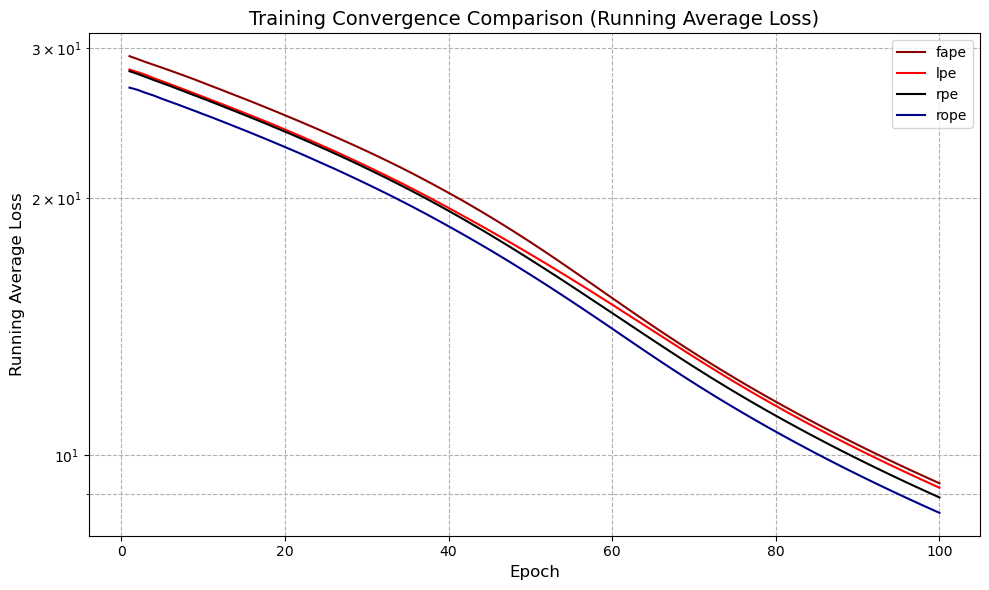

In [6]:
import matplotlib.pyplot as plt

colors = ['darkred', 'red', 'black', 'darkblue']

def plot_losses(results, pe_types, epochs):
    plt.figure(figsize=(10, 6))
    for i, pe_type in enumerate(pe_types):
        if len(results[pe_type]) == 4:
            cumulative_losses = results[pe_type][3]
            running_avg_loss = [cumulative_losses[i] / (i + 1) for i in range(len(cumulative_losses))]
            plt.plot(range(1, epochs + 1), running_avg_loss, label=f'{pe_type}', color=colors[i])
          
    plt.title('Training Convergence Comparison (Running Average Loss)', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Running Average Loss', fontsize=12)
    plt.yscale('log') # use a log scale due to large initial loss variance
    plt.legend(loc='upper right')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()

plot_losses(results, pe_types, EPOCHS)